In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
import pyproj
from math import sin, cos, sqrt, atan2, radians

In [2]:
#myproj=pyproj.Proj("""epsg:31287 +units=km +proj=lcc +lat_1=60 +lat_2=70 +lat_0=65 +lon_0=25. +x_0=400000 +y_0=400000 +datum=hermannskogel +no_defs +ellps=bessel +towgs84=577.326,90.129,463.919,5.137,1.474,5.297,2.4232""")
def make_proj(NX, NY, d, center_lon = 15.83, center_lat = 48.3, k=1.):
    proj_string = "epsg:31287 +proj=stere +units=km +lon_0={:.3f} lat_0={:.3f} +k_0={:.15f}".format(
        center_lon, center_lat, k)
    myproj=pyproj.Proj(proj_string)
    X=np.arange(NX) - NX/2.
    Y=np.arange(NY) - NY/2.
    XX, YY = np.meshgrid(d * X, d * Y)
    lon,lat=myproj(XX, YY, inverse=True)
    return lon, lat

In [3]:
R = 6373.0

def dist(lon1, lat1, lon2, lat2):
    dlon = radians(lon2) - radians(lon1)
    dlat = radians(lat2) - radians(lat1)

    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

def calc_distance(lon1, lat1, lon2, lat2):
    # Approximate radius of earth in km
    d = np.zeros(lon1.shape)
    imax, jmax = lon1.shape
    for ii in range(imax):
        for jj in range(jmax):
            dlon = radians(lon2[ii, jj]) - radians(lon1[ii, jj])
            dlat = radians(lat2[ii, jj]) - radians(lat1[ii, jj])

            a = sin(dlat / 2)**2 + cos(radians(lat1[ii, jj])) * cos(radians(lat2[ii, jj])) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            d[ii, jj] = R * c
    return d

Optimizing k for selected projection parameters, maximum 15 iterations:
N = 000, k = 1.0000000000, bias = -0.0012231746
N = 001, k = 0.9000000000, bias = 0.1097417345
N = 002, k = 0.9500000000, bias = 0.0513395374
N = 003, k = 0.9750000000, bias = 0.0243843850
N = 004, k = 0.9875000000, bias = 0.0114185519
N = 005, k = 0.9937500000, bias = 0.0050579396
N = 006, k = 0.9968750000, bias = 0.0019075387
N = 007, k = 0.9984375000, bias = 0.0003397327
N = 008, k = 0.9992187500, bias = -0.0004423319
N = 009, k = 0.9988281250, bias = -0.0000514525
N = 010, k = 0.9986328125, bias = 0.0001441018
N = 011, k = 0.9987304688, bias = 0.0000463151
N = 012, k = 0.9987792969, bias = -0.0000025711
N = 013, k = 0.9987548828, bias = 0.0000218714
N = 014, k = 0.9987670898, bias = 0.0000096500
Using k = 0.9987731934 for projection.
0.9971059229444047 1.001685701142744


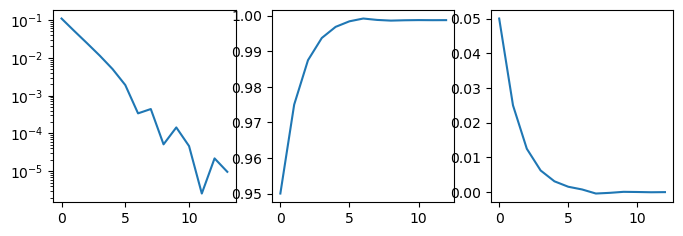

In [29]:
nx = 200.
ny = nx
d = 1.

lon1, lat1 = make_proj(nx, ny, d=d, k=1.)

xend, yend = lon1.shape

distance11 = calc_distance(lon1[0:xend-2, :], lat1[0:xend-2, :], lon1[1:xend-1, :], lat1[1:xend-1, :])
distance12 = calc_distance(lon1[:, 0:yend-2], lat1[:, 0:yend-2], lon1[:, 1:yend-1], lat1[:, 1:yend-1])
k = 1.
# kstep = 0.01 * d

ks = []
ksteps = []
ds = [1e20]
def err(arr, val, score="bias"):
    """ return score for array and constant val"""
    if score.lower() == "bias":
        return np.mean(arr - val)
#     elif score.lower() == "mae":
#         return np.mean(np.abs(arr-val))
#     elif score.lower() == "rmse":
#         return np.sqrt(np.mean(np.square(np.abs(arr-val))))

score = "bias"
maxiter = 15
kstep = 0.1
print("Optimizing k for selected projection parameters, maximum {:d} iterations:".format(maxiter))
for ii in range(maxiter):
    lon2, lat2 = make_proj(nx, ny, d=d, k=k)
    distance21 = calc_distance(lon2[0:xend-2, :], lat2[0:xend-2, :], lon2[1:xend-1, :], lat2[1:xend-1, :])
    distance22 = calc_distance(lon2[:, 0:yend-2], lat2[:, 0:yend-2], lon2[:, 1:yend-1], lat2[:, 1:yend-1])
    dbias = 0.5 * (np.mean(distance21) + np.mean(distance22)) - 1.
    ks.append(k)
    ksteps.append(kstep)
    ds.append(dbias)
    print("N = {:03d}, k = {:.10f}, {:s} = {:.10f}".format(ii, k, score, dbias))
    kstep = -kstep  if dbias * ds[-2] < 0. else kstep
    if ii > 0:
        kstep *= 0.5
    k += kstep
    

print("Using k = {:.10f} for projection.".format(k))

ks = np.array(ks)
ds = np.array(ds)

fig, axs = plt.subplots(1,3, figsize=(8,2.5))
axs[0].plot(np.abs(ds[2::]))
axs[0].set_yscale('log')
axs[1].plot(ks[2::])
axs[2].plot(ksteps[2::])

dist_min_global = np.min(np.array([
    distance11.min(), distance12.min(), distance21.min(), distance22.min()]))
dist_max_global = np.max(np.array([
    distance11.max(), distance12.max(), distance21.max(), distance22.max()]))

print(dist_min_global, dist_max_global)

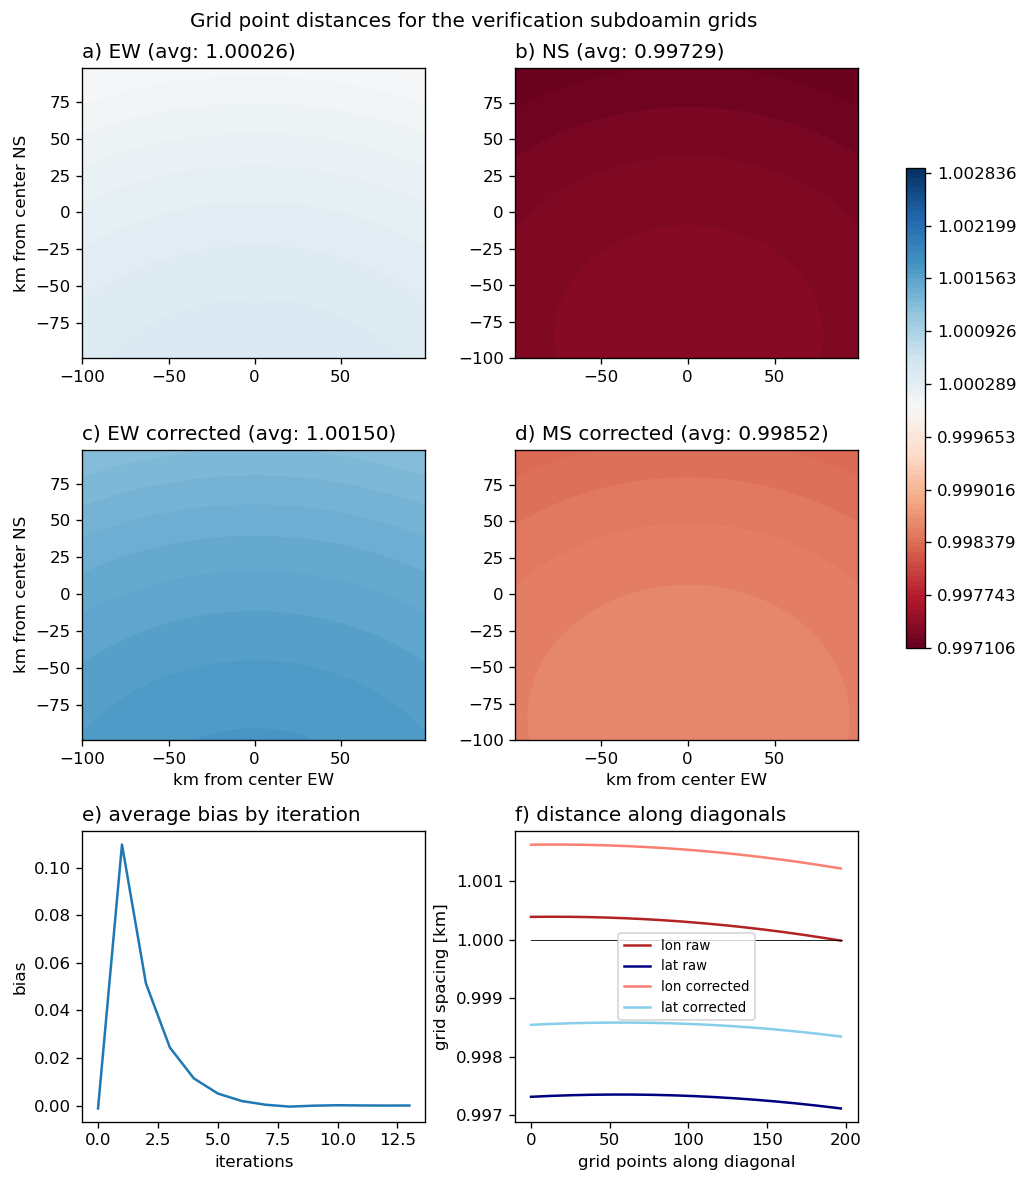

In [5]:
fig, ax = plt.subplots(3,2, figsize=(8,10), dpi=120)

lev_limit = np.max(np.abs(np.array([dist_min_global - d, dist_max_global - d])))
d_lev = 2 * lev_limit / 100.
levels = np.arange(d - lev_limit, d + lev_limit + 0.01 * d_lev, d_lev)

idx_long = d * np.array(range(int(-nx/2), int(nx/2)))
idx_shor = d * np.array(range(int(-nx/2+1), int(nx/2-1)))

c1 = ax[0][0].contourf(idx_long, idx_shor, distance11, levels=levels, cmap="RdBu")
c2 = ax[0][1].contourf(idx_shor, idx_long, distance12, levels=levels, cmap="RdBu")
c3 = ax[1][0].contourf(idx_long, idx_shor, distance21, levels=levels, cmap="RdBu")
c4 = ax[1][1].contourf(idx_shor, idx_long, distance22, levels=levels, cmap="RdBu")
ax[0][0].set_title("a) EW (avg: {:.5f})".format(np.mean(distance11)), loc='left')
ax[0][1].set_title("b) NS (avg: {:.5f})".format(np.mean(distance12)), loc='left')
ax[1][0].set_title("c) EW corrected (avg: {:.5f})".format(np.mean(distance21)), loc='left')
ax[1][1].set_title("d) MS corrected (avg: {:.5f})".format(np.mean(distance22)), loc='left')
ax[0][0].set_ylabel("km from center NS")
ax[1][0].set_ylabel("km from center NS")
ax[1][0].set_xlabel("km from center EW")
ax[1][1].set_xlabel("km from center EW")
# plt.colorbar(c1, ax=ax[0][0])
# plt.colorbar(c2, ax=ax[0][1])
# plt.colorbar(c3, ax=ax[1][0])
# plt.colorbar(c4, ax=ax[1][1])
ax[2][0].plot(ds[1:len(ds)-1])
ax[2][0].set_title("e) average bias by iteration", loc="left")
ax[2][0].set_xlabel("iterations")
ax[2][0].set_ylabel("bias")

diag = np.zeros((4, int(nx-2)))
for ii in range(int(nx-2)):
    diag[0, ii] = distance11[ii, ii]
    diag[1, ii] = distance12[ii, ii]
    diag[2, ii] = distance21[ii, ii]
    diag[3, ii] = distance22[ii, ii]

xlen = diag.shape[1]
ax[2][1].plot(diag[0, :], color = "firebrick", label="lon raw")
ax[2][1].plot(diag[1, :], color = "navy", label="lat raw")
ax[2][1].plot(diag[2, :], color = "salmon", label="lon corrected")
ax[2][1].plot(diag[3, :], color = "skyblue", label="lat corrected")
ax[2][1].plot([0., xlen], [d, d], 'k', lw=0.5)
ax[2][1].legend(prop={'size': 8})
ax[2][1].set_title("f) distance along diagonals", loc="left")
ax[2][1].set_xlabel("grid points along diagonal")
ax[2][1].set_ylabel("grid spacing [km]")
#ax[2][1].set_yscale('log')
t = plt.suptitle("Grid point distances for the verification subdoamin grids")
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.95, 0.45, 0.02, 0.4])
plt.colorbar(c1, cax=cax)
plt.show()
plt.close('all')

In [6]:
def get_array_edge(arr):
    nx, ny = np.shape(arr)
    e1 = arr[0     , :]
    e2 = arr[1::, ny-1]
    e3 = arr[nx-1, 0:ny-1][::-1]
    e4 = arr[:-1, 0][::-1]
    return np.concatenate((e1, e2, e3, e4), axis=0)
    
b = np.arange(25.).reshape(5,5)
b[2,3] = np.nan
b[2,1] = np.nan
print(b)
print(get_array_edge(b))
print(np.isnan(b).sum())

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. nan 12. nan 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]
[ 0.  1.  2.  3.  4.  9. 14. 19. 24. 23. 22. 21. 20. 15. 10.  5.  0.]
2


NameError: name 'lonmin' is not defined

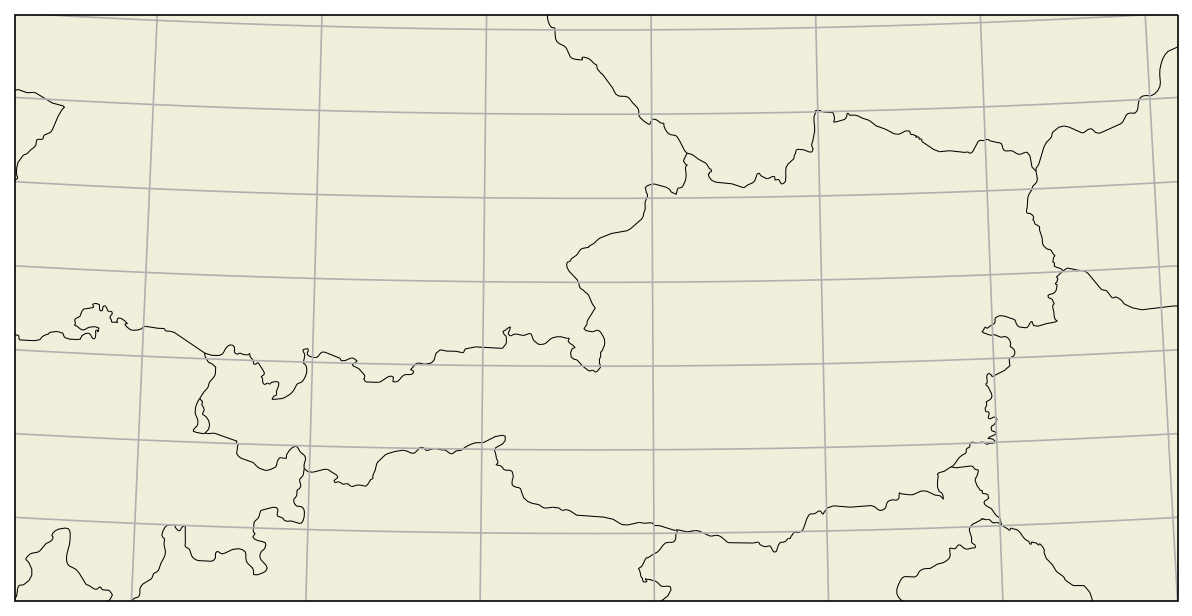

In [7]:
p = ccrs.LambertConformal(
    central_latitude = 47.75,
    central_longitude = 13.)

# p2 = ccrs.Stereographic(
#     central_latitude = 65.,
#     central_longitude = 25.)
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=p)
#ax.coastlines()
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cf.LAND)
ax.add_feature(cf.COASTLINE)
ax.add_feature(states_provinces, edgecolor='k', lw=0.5)
ax.set_extent([8., 18., 46., 49.5])
ax.gridlines()

ax.plot([lonmin, lonmin, lonmax, lonmax, lonmin],
        [latmin, latmax, latmax, latmin, latmin], 'k', lw=0.5,
        transform=ccrs.PlateCarree())
ax.plot(get_array_edge(lon2), get_array_edge(lat2), 'b', lw=0.5,
        transform=ccrs.PlateCarree())
plt.title('Hello World', loc='left')
plt.show()

In [23]:
ax.get_data_ratio()

0.5041802443216152

SyntaxError: invalid syntax (2799956027.py, line 1)

In [30]:
def optimize_domain(center_lon, center_lat, nx, ny, d=1., k=1.):

    lon1, lat1 = make_proj(nx, ny, d=d, k=1., center_lon=center_lon, center_lat=center_lat)

    xend, yend = lon1.shape

    distance11 = calc_distance(lon1[0:xend-2, :], lat1[0:xend-2, :], lon1[1:xend-1, :], lat1[1:xend-1, :])
    distance12 = calc_distance(lon1[:, 0:yend-2], lat1[:, 0:yend-2], lon1[:, 1:yend-1], lat1[:, 1:yend-1])

    ks = []
    ksteps = []
    ds = [1e20]
    maxiter = 15
    kstep = 0.1
    print("Optimizing k for selected projection parameters, maximum {:d} iterations:".format(maxiter))
    for ii in range(maxiter):
        lon2, lat2 = make_proj(nx, ny, d=d, k=k, center_lon=center_lon, center_lat=center_lat)
        distance21 = calc_distance(lon2[0:xend-2, :], lat2[0:xend-2, :], lon2[1:xend-1, :], lat2[1:xend-1, :])
        distance22 = calc_distance(lon2[:, 0:yend-2], lat2[:, 0:yend-2], lon2[:, 1:yend-1], lat2[:, 1:yend-1])
        dbias = 0.5 * (np.mean(distance21) + np.mean(distance22)) - 1.
        ks.append(k)
        ksteps.append(kstep)
        ds.append(dbias)
        print("N = {:03d}, k = {:.10f}, {:s} = {:.10f}".format(ii, k, score, dbias))
        kstep = -kstep  if dbias * ds[-2] < 0. else kstep
        if ii > 0:
            kstep *= 0.5
        k += kstep


    print("Using k = {:.10f} for projection.".format(k))

    ks = np.array(ks)
    ds = np.array(ds)

    fig, axs = plt.subplots(1,3, figsize=(8,2.5))
    axs[0].plot(np.abs(ds[2::]))
    axs[0].set_yscale('log')
    axs[0].set_title("a) Avg Distance Error", loc="left")
    axs[1].plot(ks[2::])
    axs[1].set_title("k) k", loc="left")
    axs[2].plot(ksteps[2::])
    axs[2].set_title("c) k$_{step}$", loc="left")

    dist_min_global = np.min(np.array([
        distance11.min(), distance12.min(), distance21.min(), distance22.min()]))
    dist_max_global = np.max(np.array([
        distance11.max(), distance12.max(), distance21.max(), distance22.max()]))

    print(dist_min_global, dist_max_global)
    return lon2, lat2

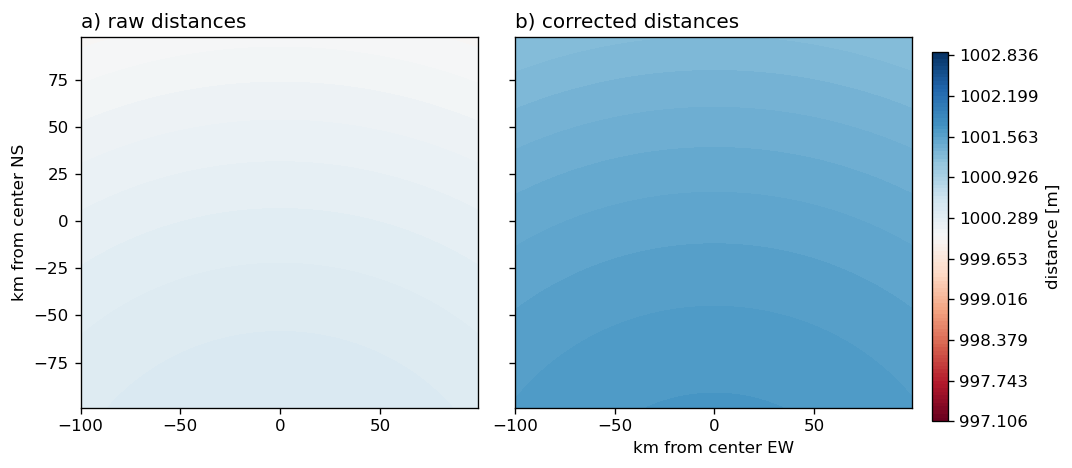

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(8.5,4), dpi=120, sharey=True, sharex=True)

lev_limit = np.max(np.abs(np.array([dist_min_global - d, dist_max_global - d])))
d_lev = 2 * lev_limit / 100.
levels = 1000. * np.arange(d - lev_limit, d + lev_limit + 0.01 * d_lev, d_lev)

idx_long = d * np.array(range(int(-nx/2), int(nx/2)))
idx_shor = d * np.array(range(int(-nx/2+1), int(nx/2-1)))

c1 = ax[0].contourf(idx_long, idx_shor, 1000. * distance11, levels=levels, cmap="RdBu")
c3 = ax[1].contourf(idx_long, idx_shor, 1000. * distance21, levels=levels, cmap="RdBu")
ax[0].set_title("a) raw distances".format(np.mean(distance11)), loc='left')
ax[1].set_title("b) corrected distances".format(np.mean(distance21)), loc='left')
ax[0].set_ylabel("km from center NS")
ax[1].set_xlabel("km from center EW")
ax[1].set_xlabel("km from center EW")
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.92, 0.11, 0.015, 0.77])
plt.colorbar(c1, cax = cax, label="distance [m]")


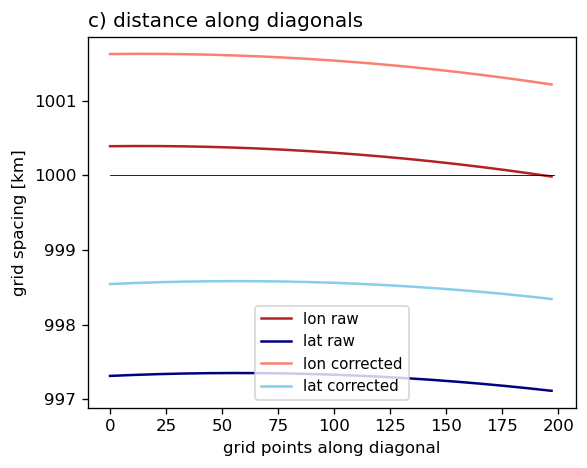

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5,4), dpi=120)
diag = np.zeros((4, int(nx-2)))
for ii in range(int(nx-2)):
    diag[0, ii] = 1000. * distance11[ii, ii]
    diag[1, ii] = 1000. * distance12[ii, ii]
    diag[2, ii] = 1000. * distance21[ii, ii]
    diag[3, ii] = 1000. * distance22[ii, ii]

xlen = diag.shape[1]
ax.plot(diag[0, :], color = "firebrick", label="lon raw")
ax.plot(diag[1, :], color = "navy", label="lat raw")
ax.plot(diag[2, :], color = "salmon", label="lon corrected")
ax.plot(diag[3, :], color = "skyblue", label="lat corrected")
ax.plot([0., xlen], [1000. * d, 1000. * d], 'k', lw=0.5)

ax.set_title("c) distance along diagonals", loc="left")
ax.set_xlabel("grid points along diagonal")
ax.set_ylabel("grid spacing [km]")
plt.tight_layout()

ax.legend(prop={'size': 9}, loc='lower center') #, bbox_to_anchor=(1., 0.5))
# fig.subplots_adjust(right=0.8)
# cax = fig.add_axes([0.88, 0.45, 0.04, 0.4])
# plt.colorbar(c1, cax=cax)
# cax.set_title('distance\n[m]', loc='left')
plt.show()
plt.close('all')

225.85242215685247 218.02532029811996 200.2136998132785
Optimizing k for selected projection parameters, maximum 15 iterations:
N = 000, k = 1.0000000000, bias = -0.0012289764
N = 001, k = 0.9000000000, bias = 0.1097340796
N = 002, k = 0.9500000000, bias = 0.0513329029
N = 003, k = 0.9750000000, bias = 0.0243781874
N = 004, k = 0.9875000000, bias = 0.0114125570
N = 005, k = 0.9937500000, bias = 0.0050520424
N = 006, k = 0.9968750000, bias = 0.0019016895
N = 007, k = 0.9984375000, bias = 0.0003339072
N = 008, k = 0.9992187500, bias = -0.0004481455
N = 009, k = 0.9988281250, bias = -0.0000572720
N = 010, k = 0.9986328125, bias = 0.0001382794
N = 011, k = 0.9987304688, bias = 0.0000404941
N = 012, k = 0.9987792969, bias = -0.0000083913
N = 013, k = 0.9987548828, bias = 0.0000160508
N = 014, k = 0.9987670898, bias = 0.0000038296
Using k = 0.9987731934 for projection.
0.9970915708581032 1.0016839433169067
14.305407034174278 17.34086218873394 47.4000090840822 49.20130562731486


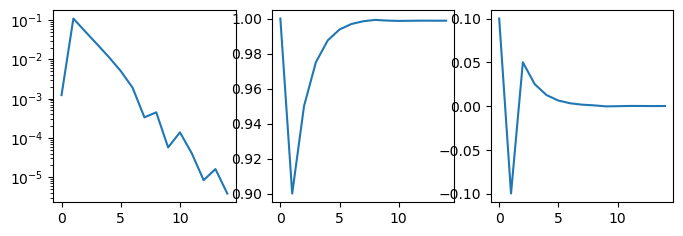

In [11]:
# old domain limits:
lonmin = 14.33
lonmax = 17.33
latmin = 47.40
latmax = 49.20

w1 = dist(14.33, 47.40, 17.33, 47.40)
w2 = dist(14.33, 49.20, 17.33, 49.20)
h = dist(14.33, 47.40, 14.33, 49.20)

print(w1, w2, h)
np.round(w1)
nx = int(np.round(0.5 * (w1 + w2)))
ny = int(np.round(h))

# new domain definition:
lon, lat = optimize_domain(15.83, 48.31, nx, ny)
print(lon.min(), lon.max(), lat.min(), lat.max())

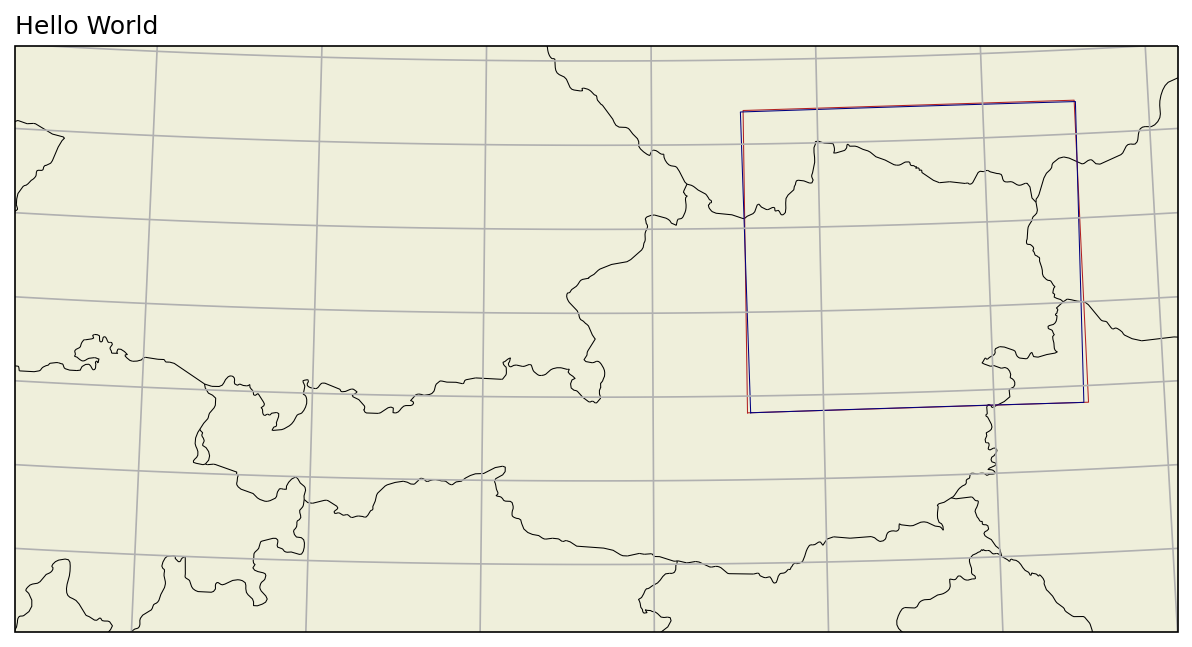

In [12]:
fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=p)

ax.add_feature(cf.LAND)
ax.add_feature(cf.COASTLINE)
ax.add_feature(states_provinces, edgecolor='k', lw=0.5)
ax.set_extent([8., 18., 46., 49.5])
ax.gridlines()

ax.plot([lonmin, lonmin, lonmax, lonmax, lonmin],
        [latmin, latmax, latmax, latmin, latmin], 'firebrick', lw=0.5,
        transform=ccrs.PlateCarree())

ax.plot(get_array_edge(lon), get_array_edge(lat), 'navy', lw=0.5,
        transform=ccrs.PlateCarree())
plt.title('Hello World', loc='left')
plt.show()

Center of Carinthia set to (13.995, 46.700)
Lon size: 201.773, 218.025 averaged to: 209.90 (210 points)
Lat size: 111.230 (111)
Optimizing k for selected projection parameters, maximum 15 iterations:
N = 000, k = 1.0000000000, bias = -0.0010243790
N = 001, k = 0.9000000000, bias = 0.1099657368
N = 002, k = 0.9500000000, bias = 0.0515501565
N = 003, k = 0.9750000000, bias = 0.0245889153
N = 004, k = 0.9875000000, bias = 0.0116201725
N = 005, k = 0.9937500000, bias = 0.0052581374
N = 006, k = 0.9968750000, bias = 0.0021070328
N = 007, k = 0.9984375000, bias = 0.0005388769
N = 008, k = 0.9992187500, bias = -0.0002433621
N = 009, k = 0.9988281250, bias = 0.0001476044
N = 010, k = 0.9990234375, bias = -0.0000479171
N = 011, k = 0.9989257813, bias = 0.0000498341
N = 012, k = 0.9989746094, bias = 0.0000009561
N = 013, k = 0.9989990234, bias = -0.0000234811
N = 014, k = 0.9989868164, bias = -0.0000112626
Using k = 0.9989807129 for projection.
0.9972809338213168 1.001695530815399
12.60833557328

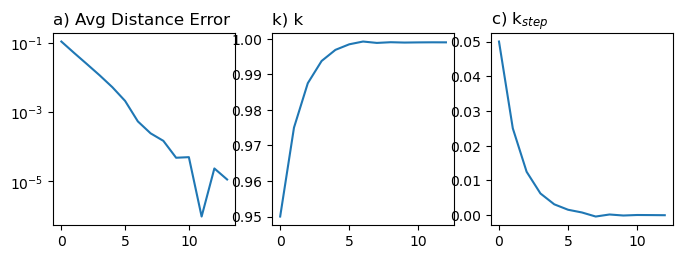

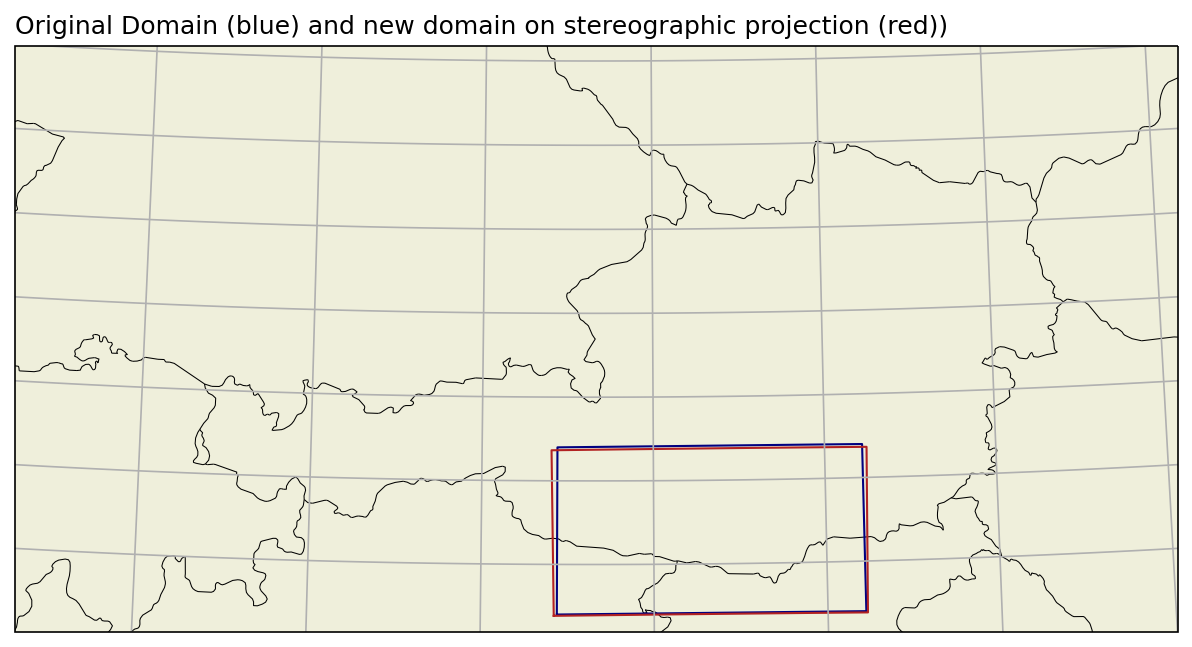

In [32]:
# old domain limits:
subdomains = {
    "Lower_Austria": {"lonmin": 14.33, "lonmax": 17.33, "latmin": 47.40, "latmax": 49.20},
    "Carinthia":     {"lonmin": 12.66, "lonmax": 15.33, "latmin": 46.20, "latmax": 47.20},
    "Styria":        {"lonmin": 13.33, "lonmax": 16.33, "latmin": 46.20, "latmax": 48.00},
}

subdom = "Carinthia"
w1 = dist(subdomains[subdom]["lonmin"], subdomains[subdom]["latmin"], 
          subdomains[subdom]["lonmax"], subdomains[subdom]["latmin"])
w1 = dist(subdomains[subdom]["lonmin"], subdomains[subdom]["latmax"], 
          subdomains[subdom]["lonmax"], subdomains[subdom]["latmax"])
h  = dist(subdomains[subdom]["lonmin"], subdomains[subdom]["latmin"], 
          subdomains[subdom]["lonmin"], subdomains[subdom]["latmax"])

midlon = 0.5 * (subdomains[subdom]["lonmin"] + subdomains[subdom]["lonmax"])
midlat = 0.5 * (subdomains[subdom]["latmin"] + subdomains[subdom]["latmax"])

# w1 = dist(14.33, 47.40, 17.33, 47.40)
# w2 = dist(14.33, 49.20, 17.33, 49.20)
# h = dist(14.33, 47.40, 14.33, 49.20)

lx = 0.5 * (w1 + w2)
nx = int(np.round(lx))
ny = int(np.round(h))
print("Center of {:s} set to ({:.3f}, {:.3f})".format(subdom, midlon, midlat))
print("Lon size: {:.3f}, {:.3f} averaged to: {:.2f} ({:d} points)".format(w1, w2, lx, nx))
print("Lat size: {:.3f} ({:d})".format(h, ny))
# new domain definition:
lon, lat = optimize_domain(midlon, midlat, nx, ny)
print(lon.min(), lon.max(), lat.min(), lat.max())

fig = plt.figure(figsize=(10,10), dpi=150)
ax = plt.axes(projection=p)

subdom_dict = {"central_longitude": midlon, "central_latitude": midlat, "size_x": nx, "size_y": ny}
print(repr(subdom_dict))

ax.add_feature(cf.LAND)
ax.add_feature(cf.COASTLINE)
ax.add_feature(states_provinces, edgecolor='k', lw=0.5)
ax.set_extent([8., 18., 46., 49.5])
ax.gridlines()

ax.plot([subdomains[subdom]["lonmin"], 
         subdomains[subdom]["lonmin"], 
         subdomains[subdom]["lonmax"], 
         subdomains[subdom]["lonmax"], 
         subdomains[subdom]["lonmin"]],
        [subdomains[subdom]["latmin"], 
         subdomains[subdom]["latmax"], 
         subdomains[subdom]["latmax"], 
         subdomains[subdom]["latmin"], 
         subdomains[subdom]["latmin"]], 
        'navy', lw=1.,
        transform=ccrs.PlateCarree())

ax.plot(get_array_edge(lon), get_array_edge(lat), 'firebrick', lw=1.,
        transform=ccrs.PlateCarree())
plt.title('Original Domain (blue) and new domain on stereographic projection (red))', loc='left')
plt.show()

In [34]:
x = np.array([1., 1., 2., 1.])
x+0.5

array([1.5, 1.5, 2.5, 1.5])